# HDP spell-sound analyzer

developed by Kow Kuroda (kow.kuroda@gmail.com)

This Jupyter Notebook was prepared for Kow Kuroda's paper presented at the 41st Annual Meeting of Japanese Cognitive Science Society, Tokyo (2024/10/14).

History
2024/08/19 Cython を使った cy_gen_ngrams を利用可能にした
2024/09/02 n-gram 生成の generic function を導入し，コードを簡略化
2024/09/06 term の階層クラスタリングを実装
2024/10/28 (skippy) n-gram 生成処理を高速化. Cython を使わなくてもそれなりに速くなった
2024/11/23 word の文字への分割処理を改善 (diacritics が分離する可能性を抑制) 

In [15]:
#!pip install -U pyLDAvis
#!pip install -U pandas

In [16]:
## imports
import os, sys
import pprint as pp
import unicodedata

In [17]:
## 一つ上の階層のファイルを見るように設定
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [18]:
## 必要に応じてCython のインストール
#!conda install cython -y

In [19]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [20]:
## Cython を使うかどうか
use_Cython = False
if use_Cython:
    %load_ext Cython

In [21]:
## term settings
term_classes        = [ 'spell', 'sound' ]
term_class          = term_classes[0]
ngram_is_inclusive  = True
inclusion_degree    = None

## doc settings
max_doc_size        = 11
min_doc_size        =  3
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

### boundary handling
mark_boundaries     = True # if True, n_for_ngram needs to be one-size bigger
boundary_mark       = "#"

## term setting
term_is_skippy      = True
n_for_ngram         = 4
max_gap_ratio       = 1.0
max_gap_size        = round(max_doc_size * max_gap_ratio)
print(f"term_class: {term_class}")
print(f"term_is_skippy: {term_is_skippy}")
print(f"max_gap_size: {max_gap_size}")
print(f"n_for_ngram: {n_for_ngram}")

## symbols
gap_mark            = "…"
seg_joint           = ""

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if term_class == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")

## define term_type
if term_class == 'spell':
    if term_is_skippy:
        term_type = f"sp_skippy{n_for_ngram}gram"
    else:
        term_type = f"sp_{n_for_ngram}gram"
else:
    if term_is_skippy:
        term_type = f"sn_skippy{n_for_ngram}gram"
    else:
        term_type = f"sn_{n_for_ngram}gram"
print(f"term_type: {term_type}")

max_doc_size: 11
min_doc_size: 3
term_class: spell
term_is_skippy: True
max_gap_size: 11
n_for_ngram: 4
accent_status: 
term_type: sp_skippy4gram


In [22]:
## target language
## a key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German Nouns',
                        'de_non_N_only' : 'German Non-nouns',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nl', 'ro', 'sw',
                        'ir' # This lacks sound
                    ]

## check
target_lang_key  = target_lang_keys[11]
print(f"target_lang_key: {target_lang_key}")
print(f"target lang: {target_lang_dict[target_lang_key]} [{target_lang_key}]")

## target_attr [effective only for Irish]
target_class = ""

#target_class = None # This causes an unrediable error
if target_lang_key == "ir":
    target_classes = [ 'adjectives', 'nouns', 'verbs' ]
    target_class = f"-{target_classes[3]}"
print(f"target_class: {target_class}")

target_lang_key: es_ES
target lang: Spanish (Spain) [es_ES]
target_class: 


In [23]:
## LDA/HDP
apply_term_filtering = True
## The following parameters need to be relatively large to prevent "Row sum not equal 1" error
term_minfreq       = 2
min_bot_size       = min_doc_size # 3
abuse_threshold    = 0.05 # larger value selects shorter units, smaller value selects longer units

# number of terms listed for a given topic
n_docs_to_show     = 15
n_terms_to_show    = 20
n_terms_to_save    = 120

# saving output
save_LDAvis          = False
save_topic_structure = False

# hierarchical clustering
hc_sampling_rate     = 0.02

In [78]:
## sampling
source_sampling           = True
source_sampling_rate      = 0.5
source_sampling_max_size  = 2000
second_sampling           = False
second_sampling_rate      = 0.7

In [79]:
## set target files
import glob
import pprint as pp

data_dir1     = "data/open-dict-ipa/data1"
data_dir2     = "data/open-dict-ipa/data1a"
data_dir3     = "data/wn3"
data_dir4     = "data/irish"
target_files  = glob.glob(f"{data_dir1}/*")
target_files2 = glob.glob(f"{data_dir2}/*")
target_files.extend(target_files2)
target_files3 = glob.glob(f"{data_dir3}/*")
target_files.extend(target_files3)
target_files4 = glob.glob(f"{data_dir4}/*")
target_files.extend(target_files4)
#
target_files = sorted([ file for file in target_files if ".csv" in file ])
pp.pprint(target_files)

['data/irish/word-irish-adjectives-spell.csv',
 'data/irish/word-irish-noun-phrases-spell.csv',
 'data/irish/word-irish-nouns-spell.csv',
 'data/irish/word-irish-possessives-spell.csv',
 'data/irish/word-irish-prepositions-spell.csv',
 'data/irish/word-irish-verbs-spell.csv',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/is.csv.gz',
 'data/open-dict-ipa/data1/ja.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 '

In [80]:
## get source data from files
import pandas as pd
import gzip
#target_language_key = "en_US" # can be changed to get other languages
#if target_class != "" or target_class is not None:
if target_class != "":
    target_file = [ f for f in target_files if target_lang_key in f and target_class in f ][0]
else:
    target_file = [ f for f in target_files if target_lang_key in f ][0]
print(f"processing: {target_file}")
##
if target_lang_key == "ir":
    col_names = ['spell', 'POS']
else:
    col_names = ['spell', 'sound']

##
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )

## normalize characters
raw_df['spell'] = raw_df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))

## modify sound
try:
    sounds = raw_df['sound'].apply(lambda x: x.strip('/') )
    sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
    raw_df['sound'] = sounds
except (AttributeError, KeyError):
    pass
#
raw_df.sample(10)

processing: data/open-dict-ipa/data1/es_ES.csv.gz


,spell,sound
334975,fiscalizártelas,fiskaliˈθaɾtelas
413479,memorará,memoɾaˈɾa
384199,jadeen,xaðeen
554750,surtida,suɾtiða
412601,meditaras,meðitaɾas
210643,despleguetead,despleɣeteað
217102,desurcáremos,desuˈɾkaɾemos
419077,misturen,mistuɾen
398050,llevaré,ʎeβaˈɾe
331474,fechándole,feˈtʃandole


In [81]:
## source sampling
len(raw_df)
if source_sampling:
	print(f"source sampling applied")
	if len(raw_df) >= source_sampling_max_size:
		raw_df = raw_df.sample(source_sampling_max_size)
	else:
		raw_df = raw_df.sample(round(len(raw_df) * source_sampling_rate))
## remove accent marking
if suppress_accents:
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass
## add boudary marks
if mark_boundaries:
	raw_df['spell'] = raw_df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(raw_df)

source sampling applied
                  spell            sound
582734         #usadas#         #usaðas#
62348       #aquejaron#       #akexaɾon#
221549     #diamantino#     #djamantino#
353875    #haldeábamos#     #aldeaβamos#
403340   #maliciaremos#   #maliθjaɾemos#
...                 ...              ...
148697  #cuchareteases#  #kutʃaɾeteases#
559384       #tatuases#       #tatwases#
398959   #lombrigueras#    #lombɾiɣeɾas#
7480      #academistas#    #akaðemistas#
493653  #redescubrimos#  #reðeskuβɾimos#

[2000 rows x 2 columns]


In [82]:
## generate 1-grams for spell and sound
import unicodedata
## spell
#raw_df['sp_1gram'] = raw_df['spell'].apply(lambda x: list(str(x)))
## The above is replace with the following, better code:
raw_df['sp_1gram'] = raw_df['spell'].apply(lambda x: [*unicodedata.normalize('NFC', x)])
# add column of size
raw_df['sp_size'] = raw_df['sp_1gram'].apply(lambda x: len(x))
# add column of count of '-' inside
raw_df['hyphen'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("-"))
# add column of count of '.' inside
raw_df['period'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("."))
## sound
# takes the first entry, removes '/' around
try:
    raw_df['sn_1gram'] = raw_df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass
# add column of size
try:
    raw_df['sn_size'] = raw_df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass
## check
raw_df

,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
582734,#usadas#,#usaðas#,"[#, u, s, a, d, a, s, #]",8,0,0,"[#, u, s, a, ð, a, s, #]",8
62348,#aquejaron#,#akexaɾon#,"[#, a, q, u, e, j, a, r, o, n, #]",11,0,0,"[#, a, k, e, x, a, ɾ, o, n, #]",10
221549,#diamantino#,#djamantino#,"[#, d, i, a, m, a, n, t, i, n, o, #]",12,0,0,"[#, d, j, a, m, a, n, t, i, n, o, #]",12
353875,#haldeábamos#,#aldeaβamos#,"[#, h, a, l, d, e, á, b, a, m, o, s, #]",13,0,0,"[#, a, l, d, e, a, β, a, m, o, s, #]",12
403340,#maliciaremos#,#maliθjaɾemos#,"[#, m, a, l, i, c, i, a, r, e, m, o, s, #]",14,0,0,"[#, m, a, l, i, θ, j, a, ɾ, e, m, o, s, #]",14
...,...,...,...,...,...,...,...,...
148697,#cuchareteases#,#kutʃaɾeteases#,"[#, c, u, c, h, a, r, e, t, e, a, s, e, s, #]",15,0,0,"[#, k, u, t, ʃ, a, ɾ, e, t, e, a, s, e, s, #]",15
559384,#tatuases#,#tatwases#,"[#, t, a, t, u, a, s, e, s, #]",10,0,0,"[#, t, a, t, w, a, s, e, s, #]",10
398959,#lombrigueras#,#lombɾiɣeɾas#,"[#, l, o, m, b, r, i, g, u, e, r, a, s, #]",14,0,0,"[#, l, o, m, b, ɾ, i, ɣ, e, ɾ, a, s, #]",13
7480,#academistas#,#akaðemistas#,"[#, a, c, a, d, e, m, i, s, t, a, s, #]",13,0,0,"[#, a, k, a, ð, e, m, i, s, t, a, s, #]",13


In [83]:
## filtering raw_data by size
print(f"term_type: {term_type}")
if "sp_" in term_type:
    df_filtered = raw_df[ (raw_df['sp_size'] <= max_doc_size) & (raw_df['sp_size'] >= min_doc_size) & (raw_df['hyphen'] == 0) & (raw_df['period'] == 0) ]
else:
    df_filtered = raw_df[ (raw_df['sn_size'] <= max_doc_size) & (raw_df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_type: sp_skippy4gram


,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
582734,#usadas#,#usaðas#,"[#, u, s, a, d, a, s, #]",8,0,0,"[#, u, s, a, ð, a, s, #]",8
62348,#aquejaron#,#akexaɾon#,"[#, a, q, u, e, j, a, r, o, n, #]",11,0,0,"[#, a, k, e, x, a, ɾ, o, n, #]",10
208541,#despepita#,#despepita#,"[#, d, e, s, p, e, p, i, t, a, #]",11,0,0,"[#, d, e, s, p, e, p, i, t, a, #]",11
214184,#destaraba#,#destaɾaβa#,"[#, d, e, s, t, a, r, a, b, a, #]",11,0,0,"[#, d, e, s, t, a, ɾ, a, β, a, #]",11
173471,#descebaré#,#desθeβaɾe#,"[#, d, e, s, c, e, b, a, r, é, #]",11,0,0,"[#, d, e, s, θ, e, β, a, ɾ, e, #]",11
...,...,...,...,...,...,...,...,...
567516,#tosigaban#,#tosiɣaβan#,"[#, t, o, s, i, g, a, b, a, n, #]",11,0,0,"[#, t, o, s, i, ɣ, a, β, a, n, #]",11
10982,#acerrojan#,#aθeroxan#,"[#, a, c, e, r, r, o, j, a, n, #]",11,0,0,"[#, a, θ, e, r, o, x, a, n, #]",10
441214,#palmiches#,#palmitʃes#,"[#, p, a, l, m, i, c, h, e, s, #]",11,0,0,"[#, p, a, l, m, i, t, ʃ, e, s, #]",11
567511,#tosieses#,#tosjeses#,"[#, t, o, s, i, e, s, e, s, #]",10,0,0,"[#, t, o, s, j, e, s, e, s, #]",10


In [84]:
## define df after second sampling if any
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

773

In [85]:
## generic function for n-gram generation
def add_ngram_to_df (dfx, n_for_ngram: int, skippy: bool, prefix: str = "", seg_joint: str = "", missing_mark: str = gap_mark, max_distance = None, inclusive: bool = ngram_is_inclusive, inclusion_degree = None, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    ## variables
    source_var = f"{prefix}1gram"
    print(f"source_var: {source_var}")
    if skippy:
        target_var = f"{prefix}skippy{n_for_ngram}gram"
    else:
        target_var = f"{prefix}{n_for_ngram}gram"
    print(f"target_var: {target_var}")
    
    ##
    unigrams = dfx[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if skippy:
            #ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_skippy_ngrams(x, n = n_for_ngram, missing_mark = missing_mark, max_distance = max_distance, check = check)] for x in unigrams ]
            ## The following replaces the above
            ngrams = unigrams.apply(lambda x: cy_gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) )
            
        else:
            #ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check)] for x in unigrams ]
            ## The following replaces the above
            ngrams = unigrams.apply(lambda x: cy_gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) )
    else:
        import gen_ngrams
        if skippy:
            #ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) for x in unigrams ]
            ngrams = unigrams.apply(lambda x: gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) )
        else:
            #ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) for x in unigrams ]
            ngrams = unigrams.apply(lambda x: gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) )
    ## 包括的 n-gramの生成
    if inclusive:
        if inclusion_degree is None:
            min_size = 1
        else:
            min_size = (n_for_ngram - inclusion_degree)
        print(f"min_size: {min_size}")
        assert min_size >= 0
        if skippy and n_for_ngram > 2:
            supplement_var = f"{prefix}skippy{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            supplement = [ x for x in list(dfx[supplement_var])[i] if len(x) >= min_size ]
            if len(supplement) > 0:
                g.extend(supplement)
    ## 変数の追加
    dfx[target_var] = ngrams
    ## check result
    print(dfx[target_var])

# Spell

In [86]:
## spell 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", seg_joint = "", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_2gram
min_size: 1
supplement_var: sp_1gram
582734    [#u, us, sa, ad, da, as, s#, #, u, s, a, d, a,...
62348     [#a, aq, qu, ue, ej, ja, ar, ro, on, n#, #, a,...
208541    [#d, de, es, sp, pe, ep, pi, it, ta, a#, #, d,...
214184    [#d, de, es, st, ta, ar, ra, ab, ba, a#, #, d,...
173471    [#d, de, es, sc, ce, eb, ba, ar, ré, é#, #, d,...
                                ...                        
567516    [#t, to, os, si, ig, ga, ab, ba, an, n#, #, t,...
10982     [#a, ac, ce, er, rr, ro, oj, ja, an, n#, #, a,...
441214    [#p, pa, al, lm, mi, ic, ch, he, es, s#, #, p,...
567511    [#t, to, os, si, ie, es, se, es, s#, #, t, o, ...
559384    [#t, ta, at, tu, ua, as, se, es, s#, #, t, a, ...
Name: sp_2gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [87]:
## frequencies of 2grams
ngram_is_skippy = False
n_now = 2
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('s#', 246),
 ('ar', 221),
 ('#a', 134),
 ('as', 133),
 ('a#', 130),
 ('es', 126),
 ('ra', 125),
 ('re', 119),
 ('n#', 113),
 ('en', 111),
 ('an', 92),
 ('o#', 92),
 ('ad', 83),
 ('#e', 80),
 ('la', 80),
 ('os', 78),
 ('e#', 78),
 ('is', 73),
 ('ba', 72),
 ('#r', 69),
 ('er', 68),
 ('ta', 64),
 ('al', 61),
 ('se', 59),
 ('ca', 59),
 ('de', 58),
 ('ab', 58),
 ('da', 56),
 ('#c', 56),
 ('#d', 55)]

In [88]:
## spell 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_3gram
min_size: 1
supplement_var: sp_2gram
582734    [#us, usa, sad, ada, das, as#, #u, us, sa, ad,...
62348     [#aq, aqu, que, uej, eja, jar, aro, ron, on#, ...
208541    [#de, des, esp, spe, pep, epi, pit, ita, ta#, ...
214184    [#de, des, est, sta, tar, ara, rab, aba, ba#, ...
173471    [#de, des, esc, sce, ceb, eba, bar, aré, ré#, ...
                                ...                        
567516    [#to, tos, osi, sig, iga, gab, aba, ban, an#, ...
10982     [#ac, ace, cer, err, rro, roj, oja, jan, an#, ...
441214    [#pa, pal, alm, lmi, mic, ich, che, hes, es#, ...
567511    [#to, tos, osi, sie, ies, ese, ses, es#, #t, t...
559384    [#ta, tat, atu, tua, uas, ase, ses, es#, #t, t...
Name: sp_3gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [89]:
## frequencies of 3grams
ngram_is_skippy = False
n_now = 3
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('as#', 70),
 ('is#', 56),
 ('os#', 55),
 ('an#', 50),
 ('es#', 45),
 ('#re', 45),
 ('aba', 41),
 ('en#', 39),
 ('ara', 38),
 ('#de', 37),
 ('#en', 36),
 ('des', 35),
 ('ase', 35),
 ('are', 32),
 ('ará', 28),
 ('ada', 27),
 ('#es', 26),
 ('ra#', 26),
 ('da#', 25),
 ('aré', 24),
 ('ré#', 24),
 ('lar', 24),
 ('ado', 24),
 ('#ma', 24),
 ('ras', 24),
 ('do#', 23),
 ('res', 22),
 ('éis', 22),
 ('mos', 20),
 ('te#', 19)]

In [90]:
## spell 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_4gram
min_size: 1
supplement_var: sp_3gram
582734    [#usa, usad, sada, adas, das#, #us, usa, sad, ...
62348     [#aqu, aque, quej, ueja, ejar, jaro, aron, ron...
208541    [#des, desp, espe, spep, pepi, epit, pita, ita...
214184    [#des, dest, esta, star, tara, arab, raba, aba...
173471    [#des, desc, esce, sceb, ceba, ebar, baré, aré...
                                ...                        
567516    [#tos, tosi, osig, siga, igab, gaba, aban, ban...
10982     [#ace, acer, cerr, erro, rroj, roja, ojan, jan...
441214    [#pal, palm, almi, lmic, mich, iche, ches, hes...
567511    [#tos, tosi, osie, sies, iese, eses, ses#, #to...
559384    [#tat, tatu, atua, tuas, uase, ases, ses#, #ta...
Name: sp_4gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [91]:
## spell 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_5gram
min_size: 1
supplement_var: sp_4gram
582734    [#usad, usada, sadas, adas#, #usa, usad, sada,...
62348     [#aque, aquej, queja, uejar, ejaro, jaron, aro...
208541    [#desp, despe, espep, spepi, pepit, epita, pit...
214184    [#dest, desta, estar, stara, tarab, araba, rab...
173471    [#desc, desce, esceb, sceba, cebar, ebaré, bar...
                                ...                        
567516    [#tosi, tosig, osiga, sigab, igaba, gaban, aba...
10982     [#acer, acerr, cerro, erroj, rroja, rojan, oja...
441214    [#palm, palmi, almic, lmich, miche, iches, che...
567511    [#tosi, tosie, osies, siese, ieses, eses#, #to...
559384    [#tatu, tatua, atuas, tuase, uases, ases#, #ta...
Name: sp_5gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [92]:
## spell skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy2gram
min_size: 1
supplement_var: sp_1gram
582734    [#u, #…s, #…a, #…d, #…a, #…s, #…#, us, u…a, u…...
62348     [#a, #…q, #…u, #…e, #…j, #…a, #…r, #…o, #…n, #...
208541    [#d, #…e, #…s, #…p, #…e, #…p, #…i, #…t, #…a, #...
214184    [#d, #…e, #…s, #…t, #…a, #…r, #…a, #…b, #…a, #...
173471    [#d, #…e, #…s, #…c, #…e, #…b, #…a, #…r, #…é, #...
                                ...                        
567516    [#t, #…o, #…s, #…i, #…g, #…a, #…b, #…a, #…n, #...
10982     [#a, #…c, #…e, #…r, #…r, #…o, #…j, #…a, #…n, #...
441214    [#p, #…a, #…l, #…m, #…i, #…c, #…h, #…e, #…s, #...
567511    [#t, #…o, #…s, #…i, #…e, #…s, #…e, #…s, #…#, t...
559384    [#t, #…a, #…t, #…u, #…a, #…s, #…e, #…s, #…#, t...
Name: sp_skippy2gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [93]:
## frequencies of skippy 2grams
ngram_is_skippy = True
n_now = 2
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('a…#', 879),
 ('#…a', 875),
 ('#…#', 773),
 ('e…#', 554),
 ('r…#', 553),
 ('#…e', 552),
 ('#…r', 501),
 ('a…a', 468),
 ('#…s', 465),
 ('#…o', 383),
 ('i…#', 336),
 ('#…n', 335),
 ('e…a', 330),
 ('#…i', 319),
 ('o…#', 310),
 ('a…e', 293),
 ('a…s', 277),
 ('l…#', 275),
 ('s…#', 264),
 ('#…l', 247),
 ('s#', 246),
 ('r…a', 241),
 ('c…#', 232),
 ('n…#', 230),
 ('ar', 221),
 ('t…#', 211),
 ('d…#', 210),
 ('r…s', 201),
 ('a…r', 199),
 ('a…o', 198)]

In [94]:
## spell skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy3gram
min_size: 1
supplement_var: sp_skippy2gram
582734    [#us, #u…a, #u…d, #u…a, #u…s, #u…#, #…sa, #…s…...
62348     [#aq, #a…u, #a…e, #a…j, #a…a, #a…r, #a…o, #a…n...
208541    [#de, #d…s, #d…p, #d…e, #d…p, #d…i, #d…t, #d…a...
214184    [#de, #d…s, #d…t, #d…a, #d…r, #d…a, #d…b, #d…a...
173471    [#de, #d…s, #d…c, #d…e, #d…b, #d…a, #d…r, #d…é...
                                ...                        
567516    [#to, #t…s, #t…i, #t…g, #t…a, #t…b, #t…a, #t…n...
10982     [#ac, #a…e, #a…r, #a…r, #a…o, #a…j, #a…a, #a…n...
441214    [#pa, #p…l, #p…m, #p…i, #p…c, #p…h, #p…e, #p…s...
567511    [#to, #t…s, #t…i, #t…e, #t…s, #t…e, #t…s, #t…#...
559384    [#ta, #t…t, #t…u, #t…a, #t…s, #t…e, #t…s, #t…#...
Name: sp_skippy3gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [95]:
## frequencies of skippy 3grams
ngram_is_skippy = True
n_now = 3
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a…#', 745),
 ('#…r…#', 484),
 ('#…e…#', 474),
 ('a…a…#', 346),
 ('#…a…a', 333),
 ('#…i…#', 319),
 ('#…o…#', 291),
 ('e…a…#', 250),
 ('#…s#', 246),
 ('#…l…#', 245),
 ('a…s#', 237),
 ('#…e…a', 233),
 ('#…a…s', 222),
 ('#…n…#', 222),
 ('#…s…#', 219),
 ('a…e…#', 219),
 ('#…ar', 211),
 ('#…a…e', 208),
 ('ar…#', 206),
 ('a…r…#', 189),
 ('#…u…#', 178),
 ('#…t…#', 176),
 ('#…c…#', 176),
 ('#…o…a', 175),
 ('#…r…a', 173),
 ('r…a…#', 169),
 ('#…r…s', 166),
 ('e…r…#', 160),
 ('#…e…s', 159),
 ('r…s#', 157)]

In [96]:
## spell skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy4gram
min_size: 1
supplement_var: sp_skippy3gram
582734    [#usa, #us…d, #us…a, #us…s, #us…#, #u…ad, #u…a...
62348     [#aqu, #aq…e, #aq…j, #aq…a, #aq…r, #aq…o, #aq…...
208541    [#des, #de…p, #de…e, #de…p, #de…i, #de…t, #de…...
214184    [#des, #de…t, #de…a, #de…r, #de…a, #de…b, #de…...
173471    [#des, #de…c, #de…e, #de…b, #de…a, #de…r, #de…...
                                ...                        
567516    [#tos, #to…i, #to…g, #to…a, #to…b, #to…a, #to…...
10982     [#ace, #ac…r, #ac…r, #ac…o, #ac…j, #ac…a, #ac…...
441214    [#pal, #pa…m, #pa…i, #pa…c, #pa…h, #pa…e, #pa…...
567511    [#tos, #to…i, #to…e, #to…s, #to…e, #to…s, #to…...
559384    [#tat, #ta…u, #ta…a, #ta…s, #ta…e, #ta…s, #ta…...
Name: sp_skippy4gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [97]:
## frequencies of skippy 4grams
ngram_is_skippy = True
n_now = 4
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a…a…#', 227),
 ('#…a…s#', 197),
 ('#…ar…#', 196),
 ('#…e…a…#', 172),
 ('#…a…e…#', 147),
 ('#…r…s#', 139),
 ('#…o…a…#', 135),
 ('#…e…s#', 123),
 ('#a…a…#', 119),
 ('#…e…r…#', 118),
 ('#…r…a…#', 110),
 ('#…a…a#', 106),
 ('#…a…r…#', 105),
 ('#…i…a…#', 104),
 ('#…s…a…#', 102),
 ('#…ra…#', 95),
 ('#…a…n#', 94),
 ('#…e…e…#', 90),
 ('#…n…a…#', 90),
 ('#…e…i…#', 88),
 ('#…u…a…#', 86),
 ('a…ar…#', 85),
 ('a…a…s#', 85),
 ('#a…r…#', 84),
 ('#e…a…#', 78),
 ('#…a…o…#', 77),
 ('#…a…i…#', 77),
 ('#…r…n#', 74),
 ('#…l…a…#', 74),
 ('#a…e…#', 72)]

In [98]:
## spell skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy5gram
min_size: 1
supplement_var: sp_skippy4gram
582734    [#usad, #usa…a, #usa…s, #usa…#, #us…da, #us…d…...
62348     [#aque, #aqu…j, #aqu…a, #aqu…r, #aqu…o, #aqu…n...
208541    [#desp, #des…e, #des…p, #des…i, #des…t, #des…a...
214184    [#dest, #des…a, #des…r, #des…a, #des…b, #des…a...
173471    [#desc, #des…e, #des…b, #des…a, #des…r, #des…é...
                                ...                        
567516    [#tosi, #tos…g, #tos…a, #tos…b, #tos…a, #tos…n...
10982     [#acer, #ace…r, #ace…o, #ace…j, #ace…a, #ace…n...
441214    [#palm, #pal…i, #pal…c, #pal…h, #pal…e, #pal…s...
567511    [#tosi, #tos…e, #tos…s, #tos…e, #tos…s, #tos…#...
559384    [#tatu, #tat…a, #tat…s, #tat…e, #tat…s, #tat…#...
Name: sp_skippy5gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [99]:
## frequencies of skippy 5grams
ngram_is_skippy = True
n_now = 5
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…ar…s#', 65),
 ('#…a…a…s#', 53),
 ('#…a…ar…#', 52),
 ('#…a…as#', 47),
 ('#…e…ar…#', 45),
 ('#…a…os#', 45),
 ('#…a…an#', 39),
 ('#…ar…n#', 38),
 ('#…o…ar…#', 37),
 ('#…a…is#', 37),
 ('#…a…es#', 37),
 ('#des…#', 34),
 ('#en…a…#', 34),
 ('#a…ar…#', 33),
 ('#…a…e…s#', 33),
 ('#…aba…#', 33),
 ('#de…a…#', 32),
 ('#a…a…s#', 32),
 ('#…a…en#', 32),
 ('#re…a…#', 32),
 ('#des…a', 31),
 ('#…es…a…#', 31),
 ('#…r…is#', 31),
 ('a…ar…s#', 31),
 ('#…a…r…s#', 31),
 ('#d…s…a…#', 29),
 ('#es…a…#', 29),
 ('#…i…ar…#', 29),
 ('#…u…ar…#', 28),
 ('#…e…os#', 28)]

In [100]:
## check result
target_vars = [ 'spell' ]
target_vars.extend([ f"sp_{i}gram" for i in range(1,6) ])
target_vars.extend([ f"sp_skippy{i}gram" for i in range(2,6) ])
df[target_vars]

,spell,sp_1gram,sp_2gram,sp_3gram,sp_4gram,sp_5gram,sp_skippy2gram,sp_skippy3gram,sp_skippy4gram,sp_skippy5gram
582734,#usadas#,"[#, u, s, a, d, a, s, #]","[#u, us, sa, ad, da, as, s#, #, u, s, a, d, a,...","[#us, usa, sad, ada, das, as#, #u, us, sa, ad,...","[#usa, usad, sada, adas, das#, #us, usa, sad, ...","[#usad, usada, sadas, adas#, #usa, usad, sada,...","[#u, #…s, #…a, #…d, #…a, #…s, #…#, us, u…a, u…...","[#us, #u…a, #u…d, #u…a, #u…s, #u…#, #…sa, #…s…...","[#usa, #us…d, #us…a, #us…s, #us…#, #u…ad, #u…a...","[#usad, #usa…a, #usa…s, #usa…#, #us…da, #us…d…..."
62348,#aquejaron#,"[#, a, q, u, e, j, a, r, o, n, #]","[#a, aq, qu, ue, ej, ja, ar, ro, on, n#, #, a,...","[#aq, aqu, que, uej, eja, jar, aro, ron, on#, ...","[#aqu, aque, quej, ueja, ejar, jaro, aron, ron...","[#aque, aquej, queja, uejar, ejaro, jaron, aro...","[#a, #…q, #…u, #…e, #…j, #…a, #…r, #…o, #…n, #...","[#aq, #a…u, #a…e, #a…j, #a…a, #a…r, #a…o, #a…n...","[#aqu, #aq…e, #aq…j, #aq…a, #aq…r, #aq…o, #aq…...","[#aque, #aqu…j, #aqu…a, #aqu…r, #aqu…o, #aqu…n..."
208541,#despepita#,"[#, d, e, s, p, e, p, i, t, a, #]","[#d, de, es, sp, pe, ep, pi, it, ta, a#, #, d,...","[#de, des, esp, spe, pep, epi, pit, ita, ta#, ...","[#des, desp, espe, spep, pepi, epit, pita, ita...","[#desp, despe, espep, spepi, pepit, epita, pit...","[#d, #…e, #…s, #…p, #…e, #…p, #…i, #…t, #…a, #...","[#de, #d…s, #d…p, #d…e, #d…p, #d…i, #d…t, #d…a...","[#des, #de…p, #de…e, #de…p, #de…i, #de…t, #de…...","[#desp, #des…e, #des…p, #des…i, #des…t, #des…a..."
214184,#destaraba#,"[#, d, e, s, t, a, r, a, b, a, #]","[#d, de, es, st, ta, ar, ra, ab, ba, a#, #, d,...","[#de, des, est, sta, tar, ara, rab, aba, ba#, ...","[#des, dest, esta, star, tara, arab, raba, aba...","[#dest, desta, estar, stara, tarab, araba, rab...","[#d, #…e, #…s, #…t, #…a, #…r, #…a, #…b, #…a, #...","[#de, #d…s, #d…t, #d…a, #d…r, #d…a, #d…b, #d…a...","[#des, #de…t, #de…a, #de…r, #de…a, #de…b, #de…...","[#dest, #des…a, #des…r, #des…a, #des…b, #des…a..."
173471,#descebaré#,"[#, d, e, s, c, e, b, a, r, é, #]","[#d, de, es, sc, ce, eb, ba, ar, ré, é#, #, d,...","[#de, des, esc, sce, ceb, eba, bar, aré, ré#, ...","[#des, desc, esce, sceb, ceba, ebar, baré, aré...","[#desc, desce, esceb, sceba, cebar, ebaré, bar...","[#d, #…e, #…s, #…c, #…e, #…b, #…a, #…r, #…é, #...","[#de, #d…s, #d…c, #d…e, #d…b, #d…a, #d…r, #d…é...","[#des, #de…c, #de…e, #de…b, #de…a, #de…r, #de…...","[#desc, #des…e, #des…b, #des…a, #des…r, #des…é..."
...,...,...,...,...,...,...,...,...,...,...
567516,#tosigaban#,"[#, t, o, s, i, g, a, b, a, n, #]","[#t, to, os, si, ig, ga, ab, ba, an, n#, #, t,...","[#to, tos, osi, sig, iga, gab, aba, ban, an#, ...","[#tos, tosi, osig, siga, igab, gaba, aban, ban...","[#tosi, tosig, osiga, sigab, igaba, gaban, aba...","[#t, #…o, #…s, #…i, #…g, #…a, #…b, #…a, #…n, #...","[#to, #t…s, #t…i, #t…g, #t…a, #t…b, #t…a, #t…n...","[#tos, #to…i, #to…g, #to…a, #to…b, #to…a, #to…...","[#tosi, #tos…g, #tos…a, #tos…b, #tos…a, #tos…n..."
10982,#acerrojan#,"[#, a, c, e, r, r, o, j, a, n, #]","[#a, ac, ce, er, rr, ro, oj, ja, an, n#, #, a,...","[#ac, ace, cer, err, rro, roj, oja, jan, an#, ...","[#ace, acer, cerr, erro, rroj, roja, ojan, jan...","[#acer, acerr, cerro, erroj, rroja, rojan, oja...","[#a, #…c, #…e, #…r, #…r, #…o, #…j, #…a, #…n, #...","[#ac, #a…e, #a…r, #a…r, #a…o, #a…j, #a…a, #a…n...","[#ace, #ac…r, #ac…r, #ac…o, #ac…j, #ac…a, #ac…...","[#acer, #ace…r, #ace…o, #ace…j, #ace…a, #ace…n..."
441214,#palmiches#,"[#, p, a, l, m, i, c, h, e, s, #]","[#p, pa, al, lm, mi, ic, ch, he, es, s#, #, p,...","[#pa, pal, alm, lmi, mic, ich, che, hes, es#, ...","[#pal, palm, almi, lmic, mich, iche, ches, hes...","[#palm, palmi, almic, lmich, miche, iches, che...","[#p, #…a, #…l, #…m, #…i, #…c, #…h, #…e, #…s, #...","[#pa, #p…l, #p…m, #p…i, #p…c, #p…h, #p…e, #p…s...","[#pal, #pa…m, #pa…i, #pa…c, #pa…h, #pa…e, #pa…...","[#palm, #pal…i, #pal…c, #pal…h, #pal…e, #pal…s..."
567511,#tosieses#,"[#, t, o, s, i, e, s, e, s, #]","[#t, to, os, si, ie, es, se, es, s#, #

# Sound

In [101]:
## sound 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_2gram
min_size: 1
supplement_var: sn_1gram
582734    [#u, us, sa, að, ða, as, s#, #, u, s, a, ð, a,...
62348     [#a, ak, ke, ex, xa, aɾ, ɾo, on, n#, #, a, k, ...
208541    [#d, de, es, sp, pe, ep, pi, it, ta, a#, #, d,...
214184    [#d, de, es, st, ta, aɾ, ɾa, aβ, βa, a#, #, d,...
173471    [#d, de, es, sθ, θe, eβ, βa, aɾ, ɾe, e#, #, d,...
                                ...                        
567516    [#t, to, os, si, iɣ, ɣa, aβ, βa, an, n#, #, t,...
10982     [#a, aθ, θe, er, ro, ox, xa, an, n#, #, a, θ, ...
441214    [#p, pa, al, lm, mi, it, tʃ, ʃe, es, s#, #, p,...
567511    [#t, to, os, sj, je, es, se, es, s#, #, t, o, ...
559384    [#t, ta, at, tw, wa, as, se, es, s#, #, t, a, ...
Name: sn_2gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [102]:
## sound 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_3gram
min_size: 1
supplement_var: sn_2gram
582734    [#us, usa, sað, aða, ðas, as#, #u, us, sa, að,...
62348     [#ak, ake, kex, exa, xaɾ, aɾo, ɾon, on#, #a, a...
208541    [#de, des, esp, spe, pep, epi, pit, ita, ta#, ...
214184    [#de, des, est, sta, taɾ, aɾa, ɾaβ, aβa, βa#, ...
173471    [#de, des, esθ, sθe, θeβ, eβa, βaɾ, aɾe, ɾe#, ...
                                ...                        
567516    [#to, tos, osi, siɣ, iɣa, ɣaβ, aβa, βan, an#, ...
10982     [#aθ, aθe, θer, ero, rox, oxa, xan, an#, #a, a...
441214    [#pa, pal, alm, lmi, mit, itʃ, tʃe, ʃes, es#, ...
567511    [#to, tos, osj, sje, jes, ese, ses, es#, #t, t...
559384    [#ta, tat, atw, twa, was, ase, ses, es#, #t, t...
Name: sn_3gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [103]:
## sound 4grams
add_ngram_to_df(df, n_for_ngram = 4, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_4gram
min_size: 1
supplement_var: sn_3gram
582734    [#usa, usað, saða, aðas, ðas#, #us, usa, sað, ...
62348     [#ake, akex, kexa, exaɾ, xaɾo, aɾon, ɾon#, #ak...
208541    [#des, desp, espe, spep, pepi, epit, pita, ita...
214184    [#des, dest, esta, staɾ, taɾa, aɾaβ, ɾaβa, aβa...
173471    [#des, desθ, esθe, sθeβ, θeβa, eβaɾ, βaɾe, aɾe...
                                ...                        
567516    [#tos, tosi, osiɣ, siɣa, iɣaβ, ɣaβa, aβan, βan...
10982     [#aθe, aθer, θero, erox, roxa, oxan, xan#, #aθ...
441214    [#pal, palm, almi, lmit, mitʃ, itʃe, tʃes, ʃes...
567511    [#tos, tosj, osje, sjes, jese, eses, ses#, #to...
559384    [#tat, tatw, atwa, twas, wase, ases, ses#, #ta...
Name: sn_4gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [104]:
## sound 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_5gram
min_size: 1
supplement_var: sn_4gram
582734    [#usað, usaða, saðas, aðas#, #usa, usað, saða,...
62348     [#akex, akexa, kexaɾ, exaɾo, xaɾon, aɾon#, #ak...
208541    [#desp, despe, espep, spepi, pepit, epita, pit...
214184    [#dest, desta, estaɾ, staɾa, taɾaβ, aɾaβa, ɾaβ...
173471    [#desθ, desθe, esθeβ, sθeβa, θeβaɾ, eβaɾe, βaɾ...
                                ...                        
567516    [#tosi, tosiɣ, osiɣa, siɣaβ, iɣaβa, ɣaβan, aβa...
10982     [#aθer, aθero, θerox, eroxa, roxan, oxan#, #aθ...
441214    [#palm, palmi, almit, lmitʃ, mitʃe, itʃes, tʃe...
567511    [#tosj, tosje, osjes, sjese, jeses, eses#, #to...
559384    [#tatw, tatwa, atwas, twase, wases, ases#, #ta...
Name: sn_5gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [105]:
## sound skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy2gram
min_size: 1
supplement_var: sn_1gram
582734    [#u, #…s, #…a, #…ð, #…a, #…s, #…#, us, u…a, u…...
62348     [#a, #…k, #…e, #…x, #…a, #…ɾ, #…o, #…n, #…#, a...
208541    [#d, #…e, #…s, #…p, #…e, #…p, #…i, #…t, #…a, #...
214184    [#d, #…e, #…s, #…t, #…a, #…ɾ, #…a, #…β, #…a, #...
173471    [#d, #…e, #…s, #…θ, #…e, #…β, #…a, #…ɾ, #…e, #...
                                ...                        
567516    [#t, #…o, #…s, #…i, #…ɣ, #…a, #…β, #…a, #…n, #...
10982     [#a, #…θ, #…e, #…r, #…o, #…x, #…a, #…n, #…#, a...
441214    [#p, #…a, #…l, #…m, #…i, #…t, #…ʃ, #…e, #…s, #...
567511    [#t, #…o, #…s, #…j, #…e, #…s, #…e, #…s, #…#, t...
559384    [#t, #…a, #…t, #…w, #…a, #…s, #…e, #…s, #…#, t...
Name: sn_skippy2gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [106]:
## sound skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy3gram
min_size: 1
supplement_var: sn_skippy2gram
582734    [#us, #u…a, #u…ð, #u…a, #u…s, #u…#, #…sa, #…s…...
62348     [#ak, #a…e, #a…x, #a…a, #a…ɾ, #a…o, #a…n, #a…#...
208541    [#de, #d…s, #d…p, #d…e, #d…p, #d…i, #d…t, #d…a...
214184    [#de, #d…s, #d…t, #d…a, #d…ɾ, #d…a, #d…β, #d…a...
173471    [#de, #d…s, #d…θ, #d…e, #d…β, #d…a, #d…ɾ, #d…e...
                                ...                        
567516    [#to, #t…s, #t…i, #t…ɣ, #t…a, #t…β, #t…a, #t…n...
10982     [#aθ, #a…e, #a…r, #a…o, #a…x, #a…a, #a…n, #a…#...
441214    [#pa, #p…l, #p…m, #p…i, #p…t, #p…ʃ, #p…e, #p…s...
567511    [#to, #t…s, #t…j, #t…e, #t…s, #t…e, #t…s, #t…#...
559384    [#ta, #t…t, #t…w, #t…a, #t…s, #t…e, #t…s, #t…#...
Name: sn_skippy3gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [107]:
## sound skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sn_", skippy = True, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy4gram
min_size: 1
supplement_var: sn_skippy3gram
582734    [#usa, #us…ð, #us…a, #us…s, #us…#, #u…að, #u…a...
62348     [#ake, #ak…x, #ak…a, #ak…ɾ, #ak…o, #ak…n, #ak…...
208541    [#des, #de…p, #de…e, #de…p, #de…i, #de…t, #de…...
214184    [#des, #de…t, #de…a, #de…ɾ, #de…a, #de…β, #de…...
173471    [#des, #de…θ, #de…e, #de…β, #de…a, #de…ɾ, #de…...
                                ...                        
567516    [#tos, #to…i, #to…ɣ, #to…a, #to…β, #to…a, #to…...
10982     [#aθe, #aθ…r, #aθ…o, #aθ…x, #aθ…a, #aθ…n, #aθ…...
441214    [#pal, #pa…m, #pa…i, #pa…t, #pa…ʃ, #pa…e, #pa…...
567511    [#tos, #to…j, #to…e, #to…s, #to…e, #to…s, #to…...
559384    [#tat, #ta…w, #ta…a, #ta…s, #ta…e, #ta…s, #ta…...
Name: sn_skippy4gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [108]:
## sound skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy5gram


min_size: 1
supplement_var: sn_skippy4gram
582734    [#usað, #usa…a, #usa…s, #usa…#, #us…ða, #us…ð…...
62348     [#akex, #ake…a, #ake…ɾ, #ake…o, #ake…n, #ake…#...
208541    [#desp, #des…e, #des…p, #des…i, #des…t, #des…a...
214184    [#dest, #des…a, #des…ɾ, #des…a, #des…β, #des…a...
173471    [#desθ, #des…e, #des…β, #des…a, #des…ɾ, #des…e...
                                ...                        
567516    [#tosi, #tos…ɣ, #tos…a, #tos…β, #tos…a, #tos…n...
10982     [#aθer, #aθe…o, #aθe…x, #aθe…a, #aθe…n, #aθe…#...
441214    [#palm, #pal…i, #pal…t, #pal…ʃ, #pal…e, #pal…s...
567511    [#tosj, #tos…e, #tos…s, #tos…e, #tos…s, #tos…#...
559384    [#tatw, #tat…a, #tat…s, #tat…e, #tat…s, #tat…#...
Name: sn_skippy5gram, Length: 773, dtype: object


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/2567272026.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [109]:
## check result
dropped_vars = [ 'sp_size', 'hyphen', 'period', 'sn_size' ]
if term_class == 'spell':
    extra = [ 'sn_1gram', 'sn_2gram', 'sn_3gram', 'sn_4gram',
             'sn_skippy2gram', 'sn_skippy3gram', 'sn_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]
else:
    extra = [ 'sp_1gram', 'sp_2gram', 'sp_3gram', 'sp_4gram',
             'sp_skippy2gram', 'sp_skippy3gram', 'sp_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]    
#
df[target_vars]

,spell,sound,sp_1gram,sp_2gram,sp_3gram,sp_4gram,sp_5gram,sp_skippy2gram,sp_skippy3gram,sp_skippy4gram,sp_skippy5gram,sn_5gram,sn_skippy5gram
582734,#usadas#,#usaðas#,"[#, u, s, a, d, a, s, #]","[#u, us, sa, ad, da, as, s#, #, u, s, a, d, a,...","[#us, usa, sad, ada, das, as#, #u, us, sa, ad,...","[#usa, usad, sada, adas, das#, #us, usa, sad, ...","[#usad, usada, sadas, adas#, #usa, usad, sada,...","[#u, #…s, #…a, #…d, #…a, #…s, #…#, us, u…a, u…...","[#us, #u…a, #u…d, #u…a, #u…s, #u…#, #…sa, #…s…...","[#usa, #us…d, #us…a, #us…s, #us…#, #u…ad, #u…a...","[#usad, #usa…a, #usa…s, #usa…#, #us…da, #us…d…...","[#usað, usaða, saðas, aðas#, #usa, usað, saða,...","[#usað, #usa…a, #usa…s, #usa…#, #us…ða, #us…ð…..."
62348,#aquejaron#,#akexaɾon#,"[#, a, q, u, e, j, a, r, o, n, #]","[#a, aq, qu, ue, ej, ja, ar, ro, on, n#, #, a,...","[#aq, aqu, que, uej, eja, jar, aro, ron, on#, ...","[#aqu, aque, quej, ueja, ejar, jaro, aron, ron...","[#aque, aquej, queja, uejar, ejaro, jaron, aro...","[#a, #…q, #…u, #…e, #…j, #…a, #…r, #…o, #…n, #...","[#aq, #a…u, #a…e, #a…j, #a…a, #a…r, #a…o, #a…n...","[#aqu, #aq…e, #aq…j, #aq…a, #aq…r, #aq…o, #aq…...","[#aque, #aqu…j, #aqu…a, #aqu…r, #aqu…o, #aqu…n...","[#akex, akexa, kexaɾ, exaɾo, xaɾon, aɾon#, #ak...","[#akex, #ake…a, #ake…ɾ, #ake…o, #ake…n, #ake…#..."
208541,#despepita#,#despepita#,"[#, d, e, s, p, e, p, i, t, a, #]","[#d, de, es, sp, pe, ep, pi, it, ta, a#, #, d,...","[#de, des, esp, spe, pep, epi, pit, ita, ta#, ...","[#des, desp, espe, spep, pepi, epit, pita, ita...","[#desp, despe, espep, spepi, pepit, epita, pit...","[#d, #…e, #…s, #…p, #…e, #…p, #…i, #…t, #…a, #...","[#de, #d…s, #d…p, #d…e, #d…p, #d…i, #d…t, #d…a...","[#des, #de…p, #de…e, #de…p, #de…i, #de…t, #de…...","[#desp, #des…e, #des…p, #des…i, #des…t, #des…a...","[#desp, despe, espep, spepi, pepit, epita, pit...","[#desp, #des…e, #des…p, #des…i, #des…t, #des…a..."
214184,#destaraba#,#destaɾaβa#,"[#, d, e, s, t, a, r, a, b, a, #]","[#d, de, es, st, ta, ar, ra, ab, ba, a#, #, d,...","[#de, des, est, sta, tar, ara, rab, aba, ba#, ...","[#des, dest, esta, star, tara, arab, raba, aba...","[#dest, desta, estar, stara, tarab, araba, rab...","[#d, #…e, #…s, #…t, #…a, #…r, #…a, #…b, #…a, #...","[#de, #d…s, #d…t, #d…a, #d…r, #d…a, #d…b, #d…a...","[#des, #de…t, #de…a, #de…r, #de…a, #de…b, #de…...","[#dest, #des…a, #des…r, #des…a, #des…b, #des…a...","[#dest, desta, estaɾ, staɾa, taɾaβ, aɾaβa, ɾaβ...","[#dest, #des…a, #des…ɾ, #des…a, #des…β, #des…a..."
173471,#descebaré#,#desθeβaɾe#,"[#, d, e, s, c, e, b, a, r, é, #]","[#d, de, es, sc, ce, eb, ba, ar, ré, é#, #, d,...","[#de, des, esc, sce, ceb, eba, bar, aré, ré#, ...","[#des, desc, esce, sceb, ceba, ebar, baré, aré...","[#desc, desce, esceb, sceba, cebar, ebaré, bar...","[#d, #…e, #…s, #…c, #…e, #…b, #…a, #…r, #…é, #...","[#de, #d…s, #d…c, #d…e, #d…b, #d…a, #d…r, #d…é...","[#des, #de…c, #de…e, #de…b, #de…a, #de…r, #de…...","[#desc, #des…e, #des…b, #des…a, #des…r, #des…é...","[#desθ, desθe, esθeβ, sθeβa, θeβaɾ, eβaɾe, βaɾ...","[#desθ, #des…e, #des…β, #des…a, #des…ɾ, #des…e..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
567516,#tosigaban#,#tosiɣaβan#,"[#, t, o, s, i, g, a, b, a, n, #]","[#t, to, os, si, ig, ga, ab, ba, an, n#, #, t,...","[#to, tos, osi, sig, iga, gab, aba, ban, an#, ...","[#tos, tosi, osig, siga, igab, gaba, aban, ban...","[#tosi, tosig, osiga, sigab, igaba, gaban, aba...","[#t, #…o, #…s, #…i, #…g, #…a, #…b, #…a, #…n, #...","[#to, #t…s, #t…i, #t…g, #t…a, #t…b, #t…a, #t…n...","[#tos, #to…i, #to…g, #to…a, #to…b, #to…a, #to…...","[#tosi, #tos…g, #tos…a, #tos…b, #tos…a, #tos…n...","[#tosi, tosiɣ, osiɣa, siɣaβ, iɣaβa, ɣaβan, aβa...","[#tosi, #tos…ɣ, #tos…a, #tos…β, #tos…a, #tos…n..."
10982,#acerrojan#,#aθeroxan#,"[#, a, c, e, r, r, o, j, a, n, #]","[#a, ac, ce, er, rr, ro, oj, ja, an, n#, #, a,...","[#ac, ace, cer, err, rro, roj, oja, jan, an#, ...","[#ace, acer, cerr, erro, rroj, roja, ojan, jan...","[#acer, acerr, cerro, erroj, rroja, rojan, oja...","[#a, #…c, #…e, #…r, #…r

# Analysis

In [110]:
#import matplotlib
#matplotlib.font_manager.findSystemFonts(fontpaths = None, fontext = 'ttf')

In [111]:
#import HDP_utils

In [112]:
## select data type and define doc_dict
import random
if "sp_" in term_type:
    base_type = "spell"
else:
    base_type = "sound"
doc_dict = { i: x for i, x in enumerate(df[base_type]) }
## check
random.sample(doc_dict.items(), 10)

/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_76891/1181347170.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(doc_dict.items(), 10)


[(426, '#márfagas#'),
 (509, '#naumaquia#'),
 (94, '#cabrearás#'),
 (81, '#ojalarían#'),
 (431, '#pradeños#'),
 (173, '#carcaña#'),
 (11, '#arrebolen#'),
 (91, '#hérnicos#'),
 (712, '#culeéis#'),
 (521, '#barrenen#')]

In [113]:
## select bots for analysis
enable_term_change = False # if you want to change term_type to save time and energy
if enable_term_change:
	term_type = 'sp_skippy4gram'
	print(f"(changed) term_type: {term_type}")

## bot stands for 'bag-of-terms', a generalization of 'bag-of-words'
bots = [ x for x in df[term_type] if len(x) > min_bot_size ] # Crucially
import random
random.sample(bots, 1)

[['#som',
  '#so…a',
  '#so…r',
  '#so…r',
  '#so…a',
  '#so…r',
  '#so…a',
  '#so…#',
  '#s…ma',
  '#s…m…r',
  '#s…m…r',
  '#s…m…a',
  '#s…m…r',
  '#s…m…a',
  '#s…m…#',
  '#s…ar',
  '#s…a…r',
  '#s…a…a',
  '#s…a…r',
  '#s…a…a',
  '#s…a…#',
  '#s…rr',
  '#s…r…a',
  '#s…r…r',
  '#s…r…a',
  '#s…r…#',
  '#s…ra',
  '#s…r…r',
  '#s…r…a',
  '#s…r…#',
  '#s…ar',
  '#s…a…a',
  '#s…a…#',
  '#s…ra',
  '#s…r…#',
  '#s…a#',
  '#…oma',
  '#…om…r',
  '#…om…r',
  '#…om…a',
  '#…om…r',
  '#…om…a',
  '#…om…#',
  '#…o…ar',
  '#…o…a…r',
  '#…o…a…a',
  '#…o…a…r',
  '#…o…a…a',
  '#…o…a…#',
  '#…o…rr',
  '#…o…r…a',
  '#…o…r…r',
  '#…o…r…a',
  '#…o…r…#',
  '#…o…ra',
  '#…o…r…r',
  '#…o…r…a',
  '#…o…r…#',
  '#…o…ar',
  '#…o…a…a',
  '#…o…a…#',
  '#…o…ra',
  '#…o…r…#',
  '#…o…a#',
  '#…mar',
  '#…ma…r',
  '#…ma…a',
  '#…ma…r',
  '#…ma…a',
  '#…ma…#',
  '#…m…rr',
  '#…m…r…a',
  '#…m…r…r',
  '#…m…r…a',
  '#…m…r…#',
  '#…m…ra',
  '#…m…r…r',
  '#…m…r…a',
  '#…m…r…#',
  '#…m…ar',
  '#…m…a…a',
  '#…m…a…#',
  '#…m…ra'

In [114]:
## generate dictionary
from gensim.corpora import Dictionary
diction = Dictionary(bots)
print(diction)

#apply_term_filtering = False
if apply_term_filtering:
    print(f"term filtering applied")
    diction.filter_extremes(no_below = term_minfreq, no_above = abuse_threshold)
else:
    print(f"term filtering not applied")
## check
print(diction)
## generate DTM
corpus = [ diction.doc2bow(bot) for bot in bots if len(bot) >= min_bot_size ] # Crucially

Dictionary<90993 unique tokens: ['#', '#u', '#us', '#usa', '#us…#']...>
term filtering applied
Dictionary<33620 unique tokens: ['#u', '#us', '#usa', '#us…#', '#us…a']...>


In [115]:
## sanitize corpus: HDP の場合は必須の処理
corpus = [ doc for doc in corpus if len(doc) > 0 ] # filter out empty rows 

In [116]:
## HDP (n_topics = 15)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 15
hdp15 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data15 = pyLDAvis.gensim.prepare(hdp15, corpus, diction)
pyLDAvis.display(vis_data15)

In [117]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data15, vis_output)

In [118]:
## import helper functions
import numpy as np
import HDP_helper
reload_module = True
if reload_module:
    import importlib
    importlib.reload(HDP_helper)

In [119]:
## topic investigation
target_hdp = hdp15
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.001 * #t…a + 0.001 * #t…s + 0.001 * #t…a…# + 0.001 * t…s…# + 0.001 * #t + 0.001 * os…a…# + 0.001 * #t…# + 0.001 * t…e…# + 0.001 * t…s…a + 0.001 * t…as + 0.001 * t…a…s# + 0.001 * a…u…s + 0.001 * #t…s…a + 0.001 * #to…a + 0.001 * t…i…a…# + 0.001 * #t…i…a + 0.001 * t…t…s + 0.001 * a…es + 0.001 * t…a…s + 0.001 * t…a…e
nonzero count:  256
	0.9979: #arrodilló#
	0.9975: #tosigaban#
	0.9973: #trasoñaba#
	0.9967: #traslada#
	0.9962: #tatuases#
	0.9947: #tascaba#
	0.9849: #guaro#
	0.9248: #garuan#
	0.8915: #tosida#
	0.8905: #toreabas#
	0.8821: #desloado#
	0.8381: #logis#
	0.8284: #flores#
	0.8276: #amistaban#
	0.8058: #trasteas#
topic_id 1: 0.001 * p…i…# + 0.0 * #…he…# + 0.0 * pa…m…# + 0.0 * a…h…s# + 0.0 * ic + 0.0 * #…mic + 0.0 * al…i…e + 0.0 * #…alm + 0.0 * p…i + 0.0 * #…m…e + 0.0 * al…s + 0.0 * a…ic…# + 0.0 * #…l…e…# + 0.0 * p…l…# + 0.0 * m…ch…s + 0.0 * p…ic + 0.0 * m…h…# + 0.0 * #p…s + 0.0 * m…he + 0.0 * p…l…s
nonzero count:  298
	0.9978: #prendidos#
	0.9978: #escomadas#
	0.9976

In [120]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp15.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp15_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp15_topics_out, header = False, index = None)
    print(f"saved: {hdp15_topics_out}")

33491 rows remain after density filtering, discarding 129 rows
32742 rows remain after size filtering, discarding 749 rows
65 rows remain after size filtering, discarding 32677 rows


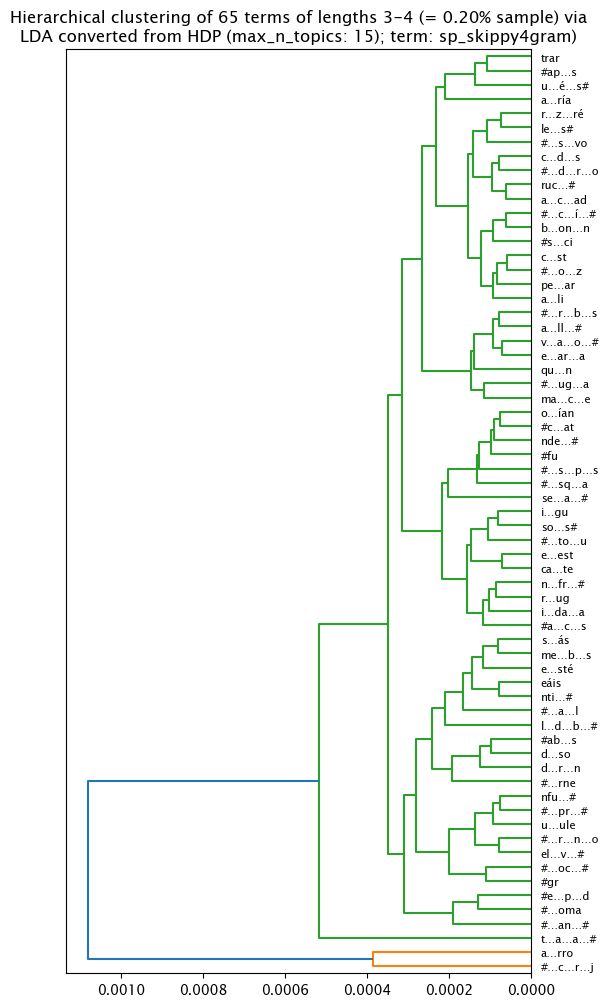

In [135]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp15, diction, term_type = term_type, n_topics= 15, lowest_density = 0.0002, max_length = n_for_ngram, min_length = 3, sampling_rate = 0.002, gap_mark = gap_mark, use_CJK = False, check = False)

In [122]:
## HDP (n_topics = 45)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 45
hdp45 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data45 = pyLDAvis.gensim.prepare(hdp45, corpus, diction)
pyLDAvis.display(vis_data45)

In [123]:
## save LDAvis output as a html file
lang_dir_name = target_lang_dict[target_lang_key].split()[0]
#save_LDAvis = True
if save_LDAvis:
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data45, vis_output)

In [124]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp45.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    #hdp45_topics_out = f"results/terms-by-topics-raw/hdp{max_n_topics}_topics_raw.csv"
    hdp45_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp45_topics_out, header = False, index = None)
    print(f"saved: {hdp45_topics_out}")

In [125]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp45
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob
#
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: {len(probs.nonzero()[0])}")
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.001 * #…h + 0.001 * a…es + 0.001 * #…a…i…s + 0.001 * m…e…# + 0.001 * a…es# + 0.001 * #…l…e…# + 0.001 * #…a…es + 0.001 * #…l…i + 0.001 * #…h…# + 0.001 * a…m + 0.001 * l…i…# + 0.001 * l…i + 0.001 * ch + 0.001 * ch…# + 0.001 * #…l…i…# + 0.001 * al…s + 0.001 * #…m…e + 0.001 * #…ch + 0.001 * #…m…e…# + 0.001 * h…s#
nonzero count: 136
	0.9976: #cabrearás#
	0.9975: #callearás#
	0.9975: #rumbareis#
	0.9975: #hambreáis#
	0.9974: #azolarais#
	0.9974: #enchicará#
	0.9974: #cazallera#
	0.9974: #sazonaras#
	0.9973: #hallarais#
	0.9973: #chicharre#
	0.9972: #palmiches#
	0.9972: #rearmares#
	0.9972: #criazones#
	0.9971: #reenviará#
	0.9971: #conchudos#
topic_id 1: 0.002 * #a…r…j + 0.002 * c…r…j…# + 0.002 * a…r…a…# + 0.002 * a…r…j + 0.002 * c…r…j + 0.002 * ac…r + 0.002 * ac…r…# + 0.002 * #ac…r + 0.002 * r…j…# + 0.002 * #…r…j…# + 0.002 * a…r…j…# + 0.002 * a…r…n# + 0.002 * #…r…j + 0.002 * #…c…r…j + 0.002 * ac…r…j + 0.002 * a…r…an + 0.002 * r…j + 0.002 * r…an# + 0.002 * ac…r…a + 0.002 * #…r…

33620 rows remain after density filtering, discarding 0 rows
33613 rows remain after size filtering, discarding 7 rows
101 rows remain after size filtering, discarding 33512 rows


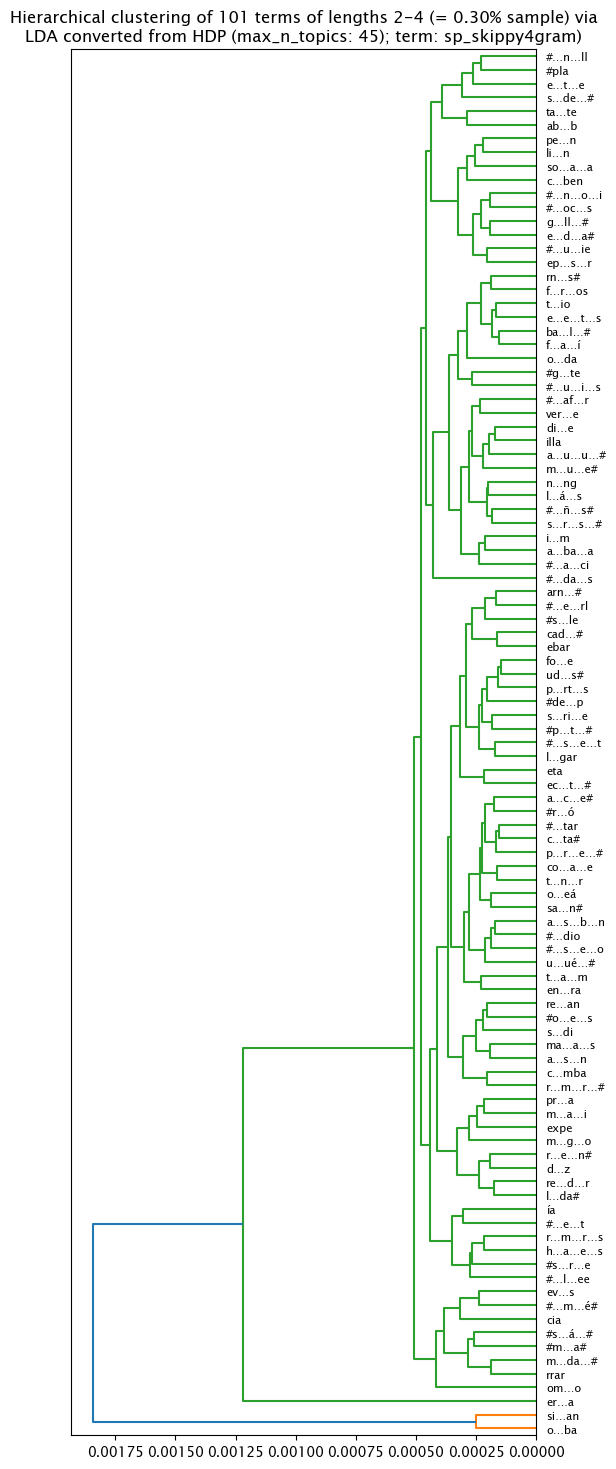

In [136]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp45, diction, term_type = term_type, n_topics = 45, lowest_density = 0.0003, max_length = n_for_ngram, min_length = 2, gap_mark = gap_mark, sampling_rate = 0.003, check = False)

In [127]:
## HDP (n_topics = 90)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 90
hdp90 = gensim.models.HdpModel(corpus, diction, T = max_n_topics,
                               random_state = 1)
vis_data90 = pyLDAvis.gensim.prepare(hdp90, corpus, diction)
pyLDAvis.display(vis_data90)

In [128]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data90, vis_output)

In [129]:
## save topic structures
if save_topic_structure:
    hdp_topics = hdp90.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }

    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp90_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp90_topics_out, header = False, index = None)
    print(f"saved: {hdp90_topics_out}")

In [130]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp90
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

## investigate topics
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    #topic_encoding = ", ".join(hdp.show_topic(topic_id))
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.002 * to…i…a + 0.002 * #t…a…# + 0.002 * #t…a + 0.002 * t…i…a + 0.002 * t…si…a + 0.002 * o…i…a…# + 0.002 * to…a + 0.002 * #t…s…a + 0.002 * t…s…a…# + 0.002 * os…a…# + 0.002 * #…os…a + 0.002 * osi…a + 0.002 * #…si…a + 0.002 * #t…i…a + 0.002 * o…i…a + 0.002 * tos…a + 0.002 * si…a…# + 0.002 * t…i…a…# + 0.002 * t…s…a + 0.002 * os…a
nonzero count:  94
	0.9975: #enchicará#
	0.9974: #tosigaban#
	0.9974: #chicharre#
	0.9973: #palmiches#
	0.9966: #mecharás#
	0.9170: #hambreáis#
	0.8695: #azolarais#
	0.8606: #repugne#
	0.8025: #rumbareis#
	0.7889: #punchar#
	0.7832: #tumbagas#
	0.7475: #margareis#
	0.7034: #reenviará#
	0.6916: #mataseis#
	0.6841: #sazonaras#
topic_id 1: 0.003 * c…r…j + 0.003 * #…c…r…j + 0.003 * #a…r…a + 0.003 * a…r…a + 0.003 * c…r…j…# + 0.003 * r…j…# + 0.003 * #…r…j + 0.003 * a…r…j + 0.003 * a…r…j…# + 0.003 * #ac…r + 0.003 * ac…r…j + 0.003 * #…r…j…# + 0.003 * ac…r…# + 0.003 * r…j + 0.003 * #a…r…j + 0.003 * ac…r + 0.003 * r…an + 0.003 * r…an# + 0.003 * r…ja…# + 0.003 

33620 rows remain after density filtering, discarding 0 rows
33613 rows remain after size filtering, discarding 7 rows
67 rows remain after size filtering, discarding 33546 rows


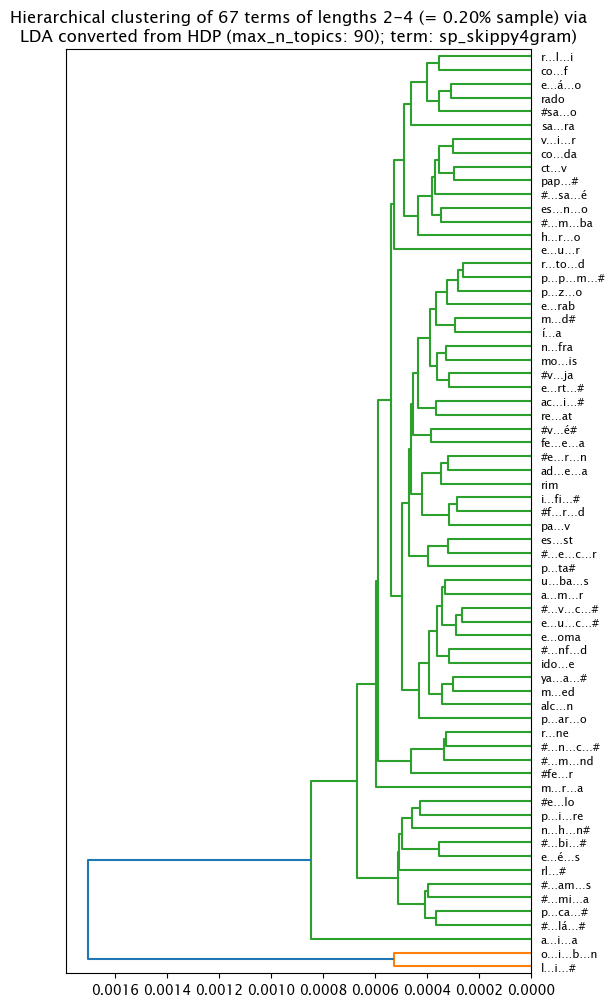

In [137]:
## term の階層クラスタリング: max_n_topics, term の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp90, diction, term_type = term_type, n_topics = 90, lowest_density = 0.0012, max_length = n_for_ngram, min_length = 2, gap_mark = gap_mark, sampling_rate = 0.002, check = False)